# Importing The Library

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import control 
import tensorflow as tf

# Calculate Routh-Hourwitz Criterion

In [29]:
#Class to call RH_Criterion
class RH_Criterion:

    def __init__(self,coeff,s1_matrice,s2_matrice):
        
        #Input Coeff's (Up to 2nd order)
        self.coeff = coeff        #initialize coeffs
        self.s1_matrice = s1_matrice   #set for s1 coeffs
        self.s2_matrice = s2_matrice   #set for s2 coeffs
        self.s3_matrice = [-np.linalg.det([s1_matrice,s2_matrice])/coeff[1], 0] #set for s3 coeffs

        #Return Value
        self.CalculateRH = self.Calculate_RH(self.coeff,
                                             self.s1_matrice,
                                             self.s2_matrice,
                                             self.s3_matrice)
    
    def Calculate_RH(self,coeff,s1_matrice,s2_matrice,s3_matrice):
        
        #Identify the criterion
        Rhcriterion = []
        if (s1_matrice[0],s2_matrice[0],s3_matrice[0] > 0 | s1_matrice[0],s2_matrice[0],s3_matrice[0] < 0):
            Rhcriterion.append("this system is stable")
        else:
            Rhcriterion.append("this system is not stable")

        #Calculate the discriminant
        Determinant = (coeff[1]**2) - (4*coeff[0]*coeff[2])

        return Rhcriterion,Determinant

if __name__ == "__main__":

    #Input Coeff's (Up to 2nd order)
    coeff = ([200,0.5,0.01])         #initialize coeffs
    s1_matrice = [coeff[0],coeff[2]]   #set for s1 coeffs
    s2_matrice = [coeff[1],0]   #set for s2 coeffs
    s3_matrice = [-np.linalg.det([s1_matrice,s2_matrice])/coeff[1], 0] #set for s3 coeffs

    print(RH_Criterion(coeff,s1_matrice,s2_matrice).CalculateRH)

(['this system is stable'], -7.75)


# Calculate Root Locus

c:\Users\altha\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\altha\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)



          1
----------------------
200 s^2 + 0.5 s + 0.01

(array([[-0.00125-6.95970545e-03j, -0.00125+6.95970545e-03j],
       [-0.00125-6.95970545e-03j, -0.00125+6.95970545e-03j],
       [-0.00125-1.13206399e-02j, -0.00125+1.13206399e-02j],
       ...,
       [-0.00125-3.16228532e+00j, -0.00125+3.16228532e+00j],
       [-0.00125-1.00000024e+01j, -0.00125+1.00000024e+01j],
       [-0.00125-3.16227774e+01j, -0.00125+3.16227774e+01j]]), array([0.00000000e+00, 0.00000000e+00, 1.59438776e-02, ...,
       2.00000000e+03, 2.00000000e+04, 2.00000000e+05]))

         0.1
----------------------
200 s^2 + 0.5 s + 0.11
,
          0.083 s + 8.3e-06
-------------------------------------
200 s^3 + 0.5 s^2 + 0.093 s + 8.3e-06



<Axes: title={'center': 'Proportional-Integral Compensator'}>

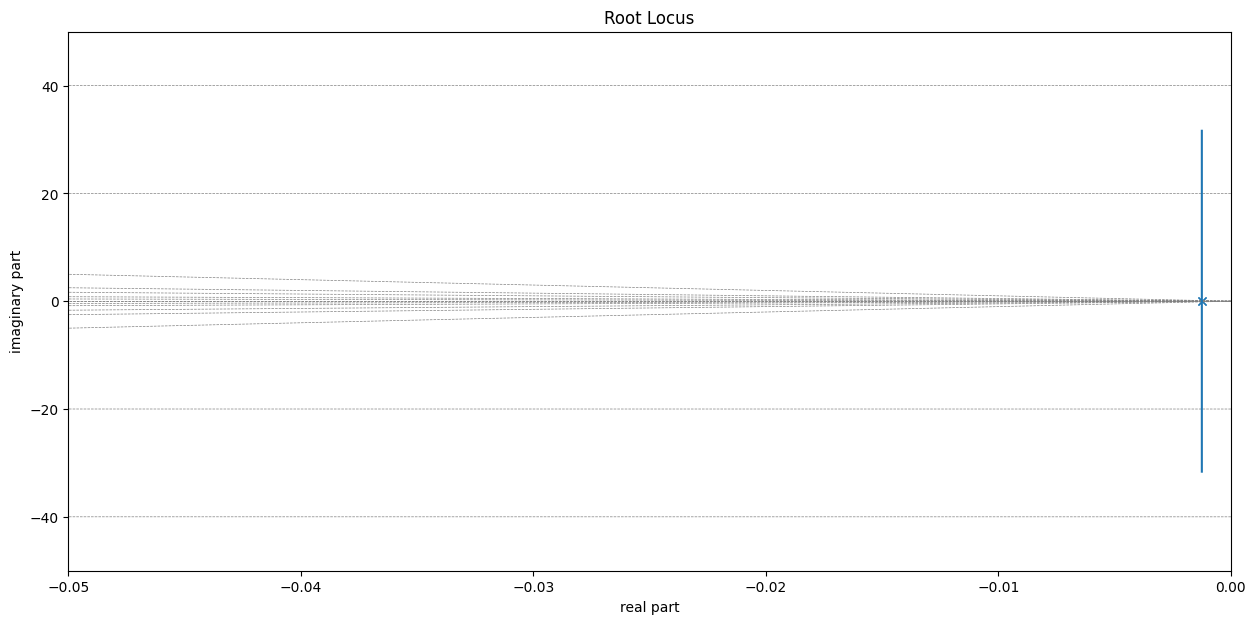

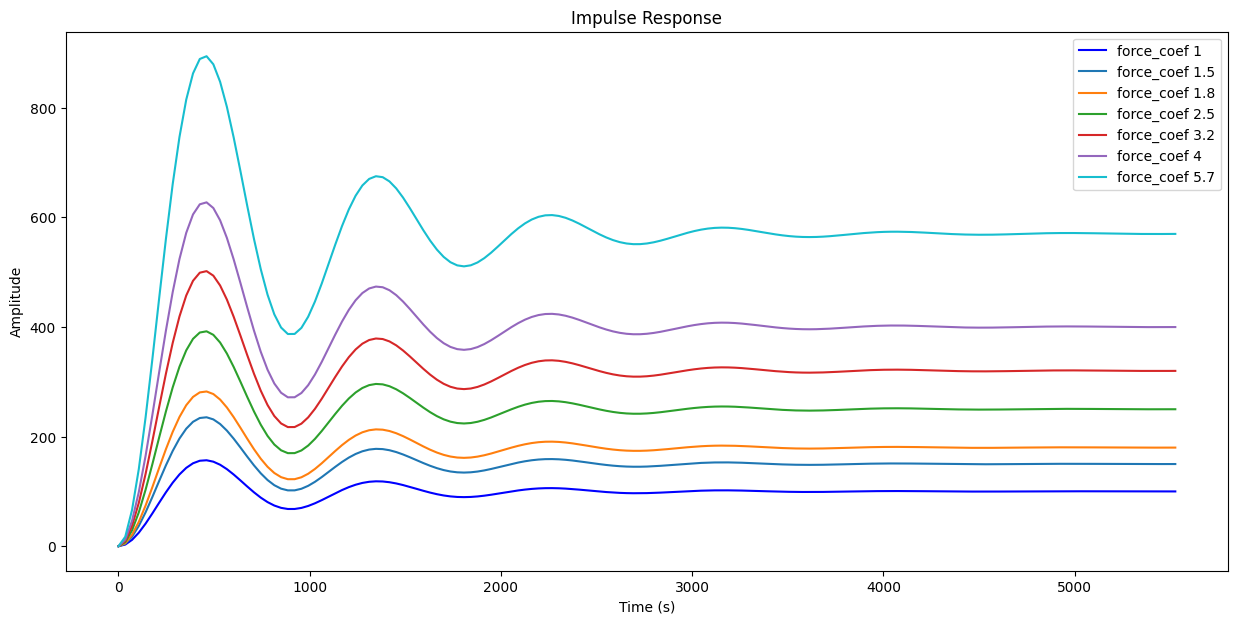

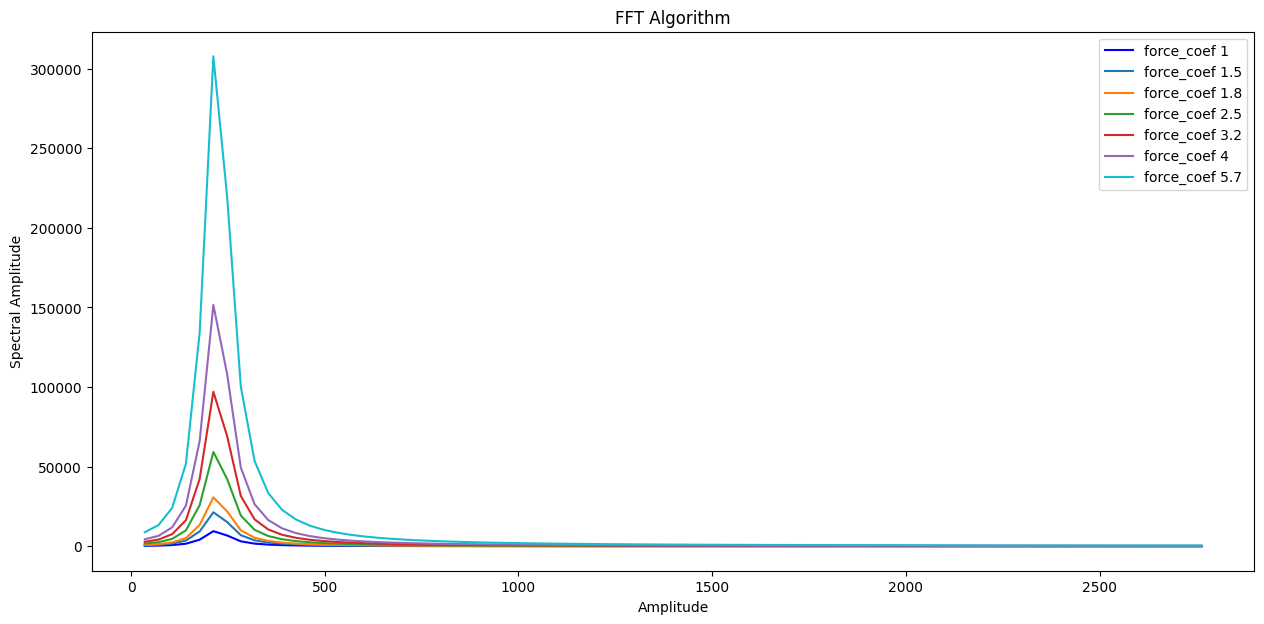

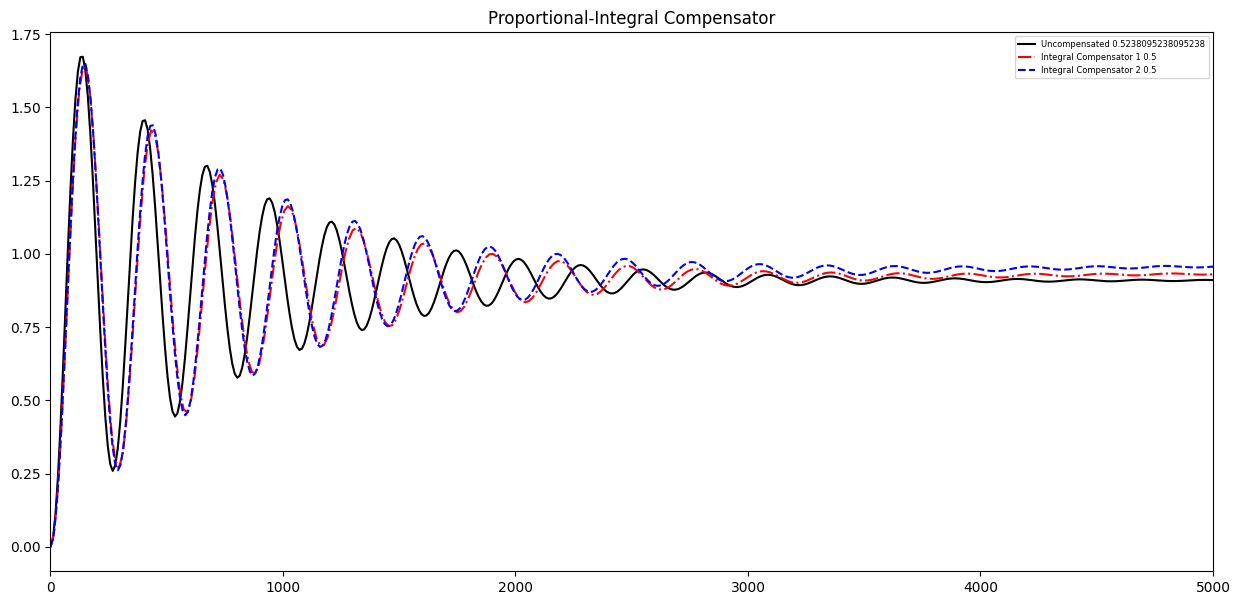

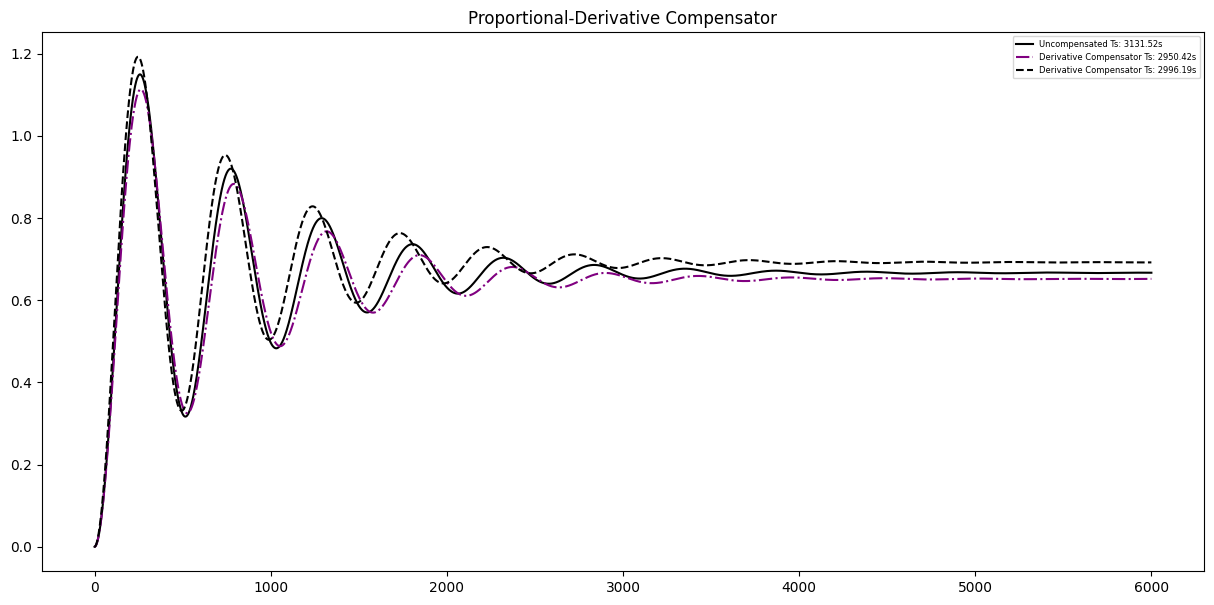

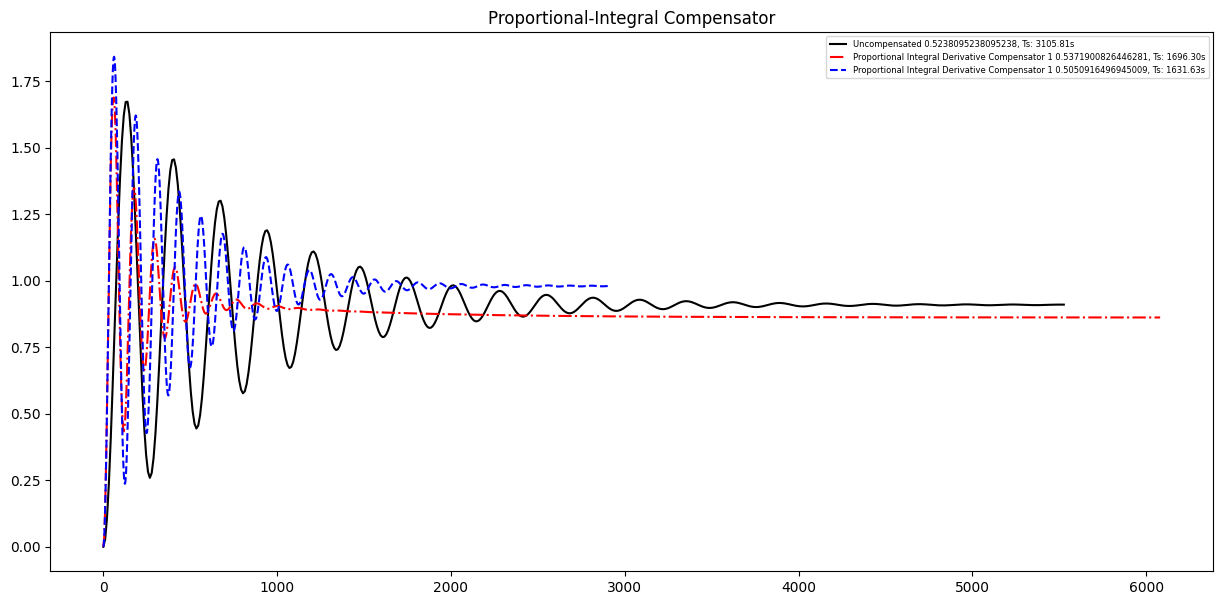

In [310]:
def Transfer_function(coeff):
    
    force_coef = [1,1.5,1.8,2.5,3.2,4,5.7]
    color = ['b','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']
    #transfer_function = control.TransferFunction([1],coeff)
    s = control.TransferFunction.s
    funct = 1/(coeff[0]*s**2 + coeff[1]*s + coeff[2])

    fig,ax = plt.subplots(figsize = (15,7))
    rlist, klist = control.rlocus(funct, xlim=[-2,0], ylim=[-50,50])
    ax.set_xlabel("real part")
    ax.set_xlim([-0.05,0])
    ax.set_ylabel("imaginary part")
    ax.set_title("Root Locus")

    time, response = control.step_response(funct)
    dt = 0.001
    PSD_I = []
    n = len(time)
    for i in force_coef:
        fhat = np.fft.fft(i*response,n)
        PSD = fhat * np.conj(fhat) / n                     # Power spectral density (power per frequency)(important)
        PSD_I.append(PSD)
    freq = (1 / (dt * n)) * np.arange(n)               # Create x-axis of frequencies
    L = np.arange(1, n/2, dtype='int')               # Only plot the first half  

    fig.savefig("File Sisken/Root Locus")


    fig,bx = plt.subplots(figsize = (15,7))

    for i in range (0,len(force_coef)):

        bx.plot(time, force_coef[i]*response, color = color[i], label = f'force_coef {force_coef[i]}')
        bx.set_title("Impulse Response")
        bx.set_xlabel("Time (s)")
        bx.set_ylabel("Amplitude")
        bx.legend()
    
    fig.savefig("File Sisken/Time Respond(s)")

    fig,cx = plt.subplots(figsize = (15,7))
    for i in range (0,len(force_coef)):
        cx.plot(time[L],PSD_I[i][L], color = color[i], label = f'force_coef {force_coef[i]}')
        cx.set_title("FFT Algorithm")
        cx.set_xlabel("Amplitude")
        cx.set_ylabel("Spectral Amplitude")
        cx.legend()
    
    fig.savefig("File Sisken/FFT Analysis")
    return ax,bx,cx,print(f'{funct}\n{control.rlocus(funct,plot=False)}')

def Integral_Compensation():
    
    s = control.TransferFunction.s
    k = 0.1 #this value agree k > -0.01
    k_1 = 0.083 #analytic proposed value with bound [0 , 66.87)
    k_2 = 0.084 #analytic proposed value with bound [0 , 66.87)
    function = k/(coeff[0]*s**2 + coeff[1]*s + coeff[2]) #Based function
    function_closed = control.feedback(function)
    Kp = control.evalfr(function_closed, 0).real
    ess = 1/(1+Kp)
    function_1 = (k_1*((s+0.0001)/(s))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
    function_1_closed = control.feedback(function_1)
    Kp_1 = control.evalfr(function_1_closed, 0).real
    ess_1 = 1/(1+Kp_1)
    function_2 = (k_2*((s+0.0002)/(s))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
    function_2_closed = control.feedback(function_2) 
    Kp_2 = control.evalfr(function_2_closed, 0).real
    ess_2 = 1/(1+Kp_2)
    #rlist, klist = control.rlocus(function, xlim=[-20,5])
    t2,y2 = control.step_response(function_2_closed) #s = 0, K = 
    t1,y1 = control.step_response(function_1_closed) #s = 0, K = 
    t,y = (control.step_response(function_closed))
    
    # Create Plot
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(t,y, color = 'black', label = f'Uncompensated {ess}')
    ax.plot(t1,y1, color = 'red', linestyle = '-.', label = f'Integral Compensator 1 {ess_1}')
    ax.plot(t2,y2, color = 'blue', linestyle = '--', label = f'Integral Compensator 2 {ess_2}')
    ax.set_xlim([0,5000])
    ax.set_title("Proportional-Integral Compensator")
    ax.legend(prop={'size':6})

    fig.savefig("File Sisken/Integral Compensation")
    return ax, print(f'{function_closed},{function_1_closed}')

def Derivative_Compensation():

    s = control.TransferFunction.s
    t = np.linspace(0, 6000, 5000)
    k = 0.02 #this value agree k > -0.01
    k_1 = 0.024 #analytic proposed value with bound [0 , 66.87)
    k_2 = 0.025 #analytic proposed value with bound [0 , 66.87)
    function = k/(coeff[0]*s**2 + coeff[1]*s + coeff[2]) #Based function
    function_closed = control.feedback(function)
    Kp = control.evalfr(function_closed, 0).real
    ess = 1/(1+Kp)
    function_1 = (k_1*((s+0.78))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
    function_1_closed = control.feedback(function_1)
    Kp_1 = control.evalfr(function_1_closed, 0).real
    ess_1 = 1/(1+Kp_1)
    function_2 = (k_2*((s+0.9))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
    function_2_closed = control.feedback(function_2)
    Kp_2 = control.evalfr(function_2_closed, 0).real
    ess_2 = 1/(1+Kp_2)
    #rlist, klist = control.rlocus(function, xlim=[-20,5])
    t2,y2 = control.step_response(function_2_closed, t) #s = 0, K = 
    info_2 = (control.step_info(function_2_closed))
    t1,y1 = control.step_response(function_1_closed, t) #s = 0, K = 
    info_1 = (control.step_info(function_1_closed))
    t,y = (control.step_response(function_closed, t))
    info = (control.step_info(function_closed))

    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(t, y, color='black', label=f"Uncompensated Ts: {info['SettlingTime']:.2f}s")
    ax.plot(t1, y1, color='purple', linestyle = '-.', label=f"Derivative Compensator Ts: {info_1['SettlingTime']:.2f}s")
    ax.plot(t2, y2, color='black', linestyle = '--',label=f"Derivative Compensator Ts: {info_2['SettlingTime']:.2f}s")
    #ax.plot(t1,y1, color = 'purple', linestyle = '-.', label = f'Integral Compensator 1 Ts:{info_1}')
    #ax.plot(t2,y2, color = 'green', linestyle = '--', label = f'Integral Compensator 2 Ts:{info_2}')
    ax.set_title("Proportional-Derivative Compensator")
    ax.legend(prop={'size':6})

    fig.savefig("File Sisken/Derivative Compensation")
    return ax

def PID_Compensation():

    s = control.TransferFunction.s
    k = 0.1 #this value agree k > -0.01
    k_1 = 0.56 #analytic proposed value with bound [0 , 66.87)
    k_2 = 0.54 #analytic proposed value with bound [0 , 66.87)
    function = k/(coeff[0]*s**2 + coeff[1]*s + coeff[2]) #Based function
    function_closed = control.feedback(function)
    Kp = control.evalfr(function_closed, 0).real
    ess = 1/(1+Kp)
    function_1 = (k_1*((s+0.001)/(s+0.009))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
    function_1_closed = control.feedback(function_1)
    Kp_1 = control.evalfr(function_1_closed, 0).real
    ess_1 = 1/(1+Kp_1)
    function_2 = (k_2*((s+0.09)/(s+0.1))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
    function_2_closed = control.feedback(function_2)
    Kp_2 = control.evalfr(function_2_closed, 0).real
    ess_2 = 1/(1+Kp_2)
    #rlist, klist = control.rlocus(function, xlim=[-20,5])
    t2,y2 = control.step_response(function_2_closed) #s = 0, K = 
    t1,y1 = control.step_response(function_1_closed) #s = 0, K = 
    t,y = (control.step_response(function_closed))
    info = (control.step_info(function_closed))
    info_1 = (control.step_info(function_1_closed))
    info_2 = (control.step_info(function_2_closed))

    # Create Plot
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(t,y, color = 'black', label = f"Uncompensated {ess}, Ts: {info['SettlingTime']:.2f}s")
    ax.plot(t1,y1, color = 'red', linestyle = '-.', label = f"Proportional Integral Derivative Compensator 1 {ess_1}, Ts: {info_1['SettlingTime']:.2f}s")
    ax.plot(t2,y2, color = 'blue', linestyle = '--', label = f"Proportional Integral Derivative Compensator 1 {ess_2}, Ts: {info_2['SettlingTime']:.2f}s")
    ax.set_title("Proportional-Integral Compensator")
    ax.legend(prop={'size':6})
    fig.savefig("File Sisken/Proportional Integral Derivative Compensation")

    return ax

Transfer_function(coeff)
Integral_Compensation()
Derivative_Compensation()
PID_Compensation()

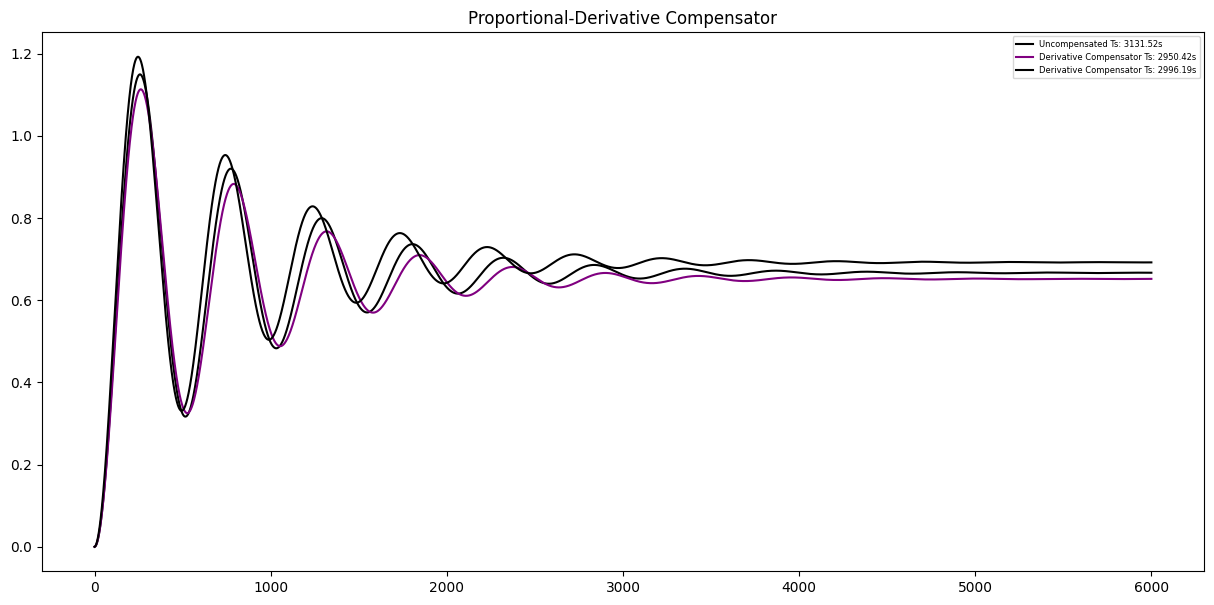

In [263]:
s = control.TransferFunction.s
t = np.linspace(0, 6000, 5000)
k = 0.02 #this value agree k > -0.01
k_1 = 0.024 #analytic proposed value with bound [0 , 66.87)
k_2 = 0.025 #analytic proposed value with bound [0 , 66.87)
function = k/(coeff[0]*s**2 + coeff[1]*s + coeff[2]) #Based function
function_closed = control.feedback(function)
Kp = control.evalfr(function_closed, 0).real
ess = 1/(1+Kp)
function_1 = (k_1*((s+0.78))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
function_1_closed = control.feedback(function_1)
Kp_1 = control.evalfr(function_1_closed, 0).real
ess_1 = 1/(1+Kp_1)
function_2 = (k_2*((s+0.9))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
function_2_closed = control.feedback(function_2)
Kp_2 = control.evalfr(function_2_closed, 0).real
ess_2 = 1/(1+Kp_2)
#rlist, klist = control.rlocus(function, xlim=[-20,5])
t2,y2 = control.step_response(function_2_closed, t) #s = 0, K = 
info_2 = (control.step_info(function_2_closed))
t1,y1 = control.step_response(function_1_closed, t) #s = 0, K = 
info_1 = (control.step_info(function_1_closed))
t,y = (control.step_response(function_closed, t))
info = (control.step_info(function_closed))

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(t, y, color='black', label=f"Uncompensated Ts: {info['SettlingTime']:.2f}s")
ax.plot(t1, y1, color='purple', label=f"Derivative Compensator Ts: {info_1['SettlingTime']:.2f}s")
ax.plot(t2, y2, color='black', label=f"Derivative Compensator Ts: {info_2['SettlingTime']:.2f}s")
#ax.plot(t1,y1, color = 'purple', linestyle = '-.', label = f'Integral Compensator 1 Ts:{info_1}')
#ax.plot(t2,y2, color = 'green', linestyle = '--', label = f'Integral Compensator 2 Ts:{info_2}')
ax.set_title("Proportional-Derivative Compensator")
ax.legend(prop={'size':6})

In [ ]:
s = control.TransferFunction.s
t = np.linspace(0, 6000, 5000)
k = 0.02 #this value agree k > -0.01
k_1 = 0.024 #analytic proposed value with bound [0 , 66.87)
k_2 = 0.025 #analytic proposed value with bound [0 , 66.87)
function = k/(coeff[0]*s**2 + coeff[1]*s + coeff[2]) #Based function
function_closed = control.feedback(function)
Kp = control.evalfr(function_closed, 0).real
ess = 1/(1+Kp)
function_1 = (k_1*((s+0.78))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
function_1_closed = control.feedback(function_1)
Kp_1 = control.evalfr(function_1_closed, 0).real
ess_1 = 1/(1+Kp_1)
function_2 = (k_2*((s+0.9))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
function_2_closed = control.feedback(function_2)
Kp_2 = control.evalfr(function_2_closed, 0).real
ess_2 = 1/(1+Kp_2)
#rlist, klist = control.rlocus(function, xlim=[-20,5])
t2,y2 = control.step_response(function_2_closed, t) #s = 0, K = 
info_2 = (control.step_info(function_2_closed))
t1,y1 = control.step_response(function_1_closed, t) #s = 0, K = 
info_1 = (control.step_info(function_1_closed))
t,y = (control.step_response(function_closed, t))
info = (control.step_info(function_closed))

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(t, y, color='black', label=f"Uncompensated Ts: {info['SettlingTime']:.2f}s")
ax.plot(t1, y1, color='purple', label=f"Derivative Compensator Ts: {info_1['SettlingTime']:.2f}s")
ax.plot(t2, y2, color='black', label=f"Derivative Compensator Ts: {info_2['SettlingTime']:.2f}s")
#ax.plot(t1,y1, color = 'purple', linestyle = '-.', label = f'Integral Compensator 1 Ts:{info_1}')
#ax.plot(t2,y2, color = 'green', linestyle = '--', label = f'Integral Compensator 2 Ts:{info_2}')
ax.set_title("Proportional-Derivative Compensator")
ax.legend(prop={'size':6})

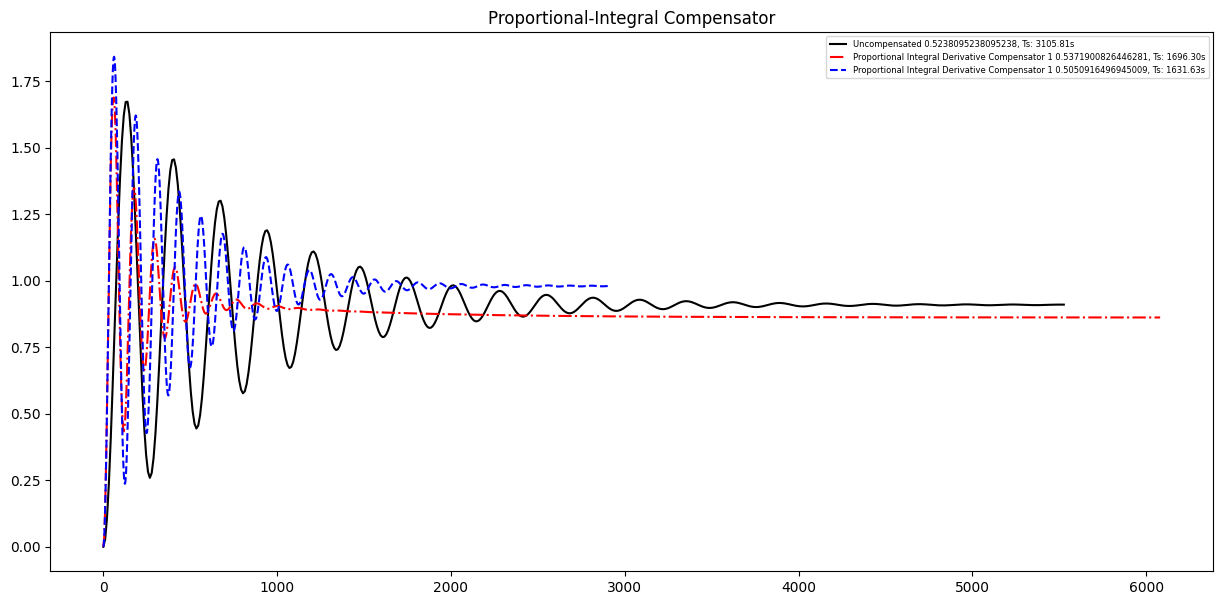

In [307]:
s = control.TransferFunction.s
k = 0.1 #this value agree k > -0.01
k_1 = 0.56 #analytic proposed value with bound [0 , 66.87)
k_2 = 0.54 #analytic proposed value with bound [0 , 66.87)
function = k/(coeff[0]*s**2 + coeff[1]*s + coeff[2]) #Based function
function_closed = control.feedback(function)
Kp = control.evalfr(function_closed, 0).real
ess = 1/(1+Kp)
function_1 = (k_1*((s+0.001)/(s+0.009))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
function_1_closed = control.feedback(function_1)
Kp_1 = control.evalfr(function_1_closed, 0).real
ess_1 = 1/(1+Kp_1)
function_2 = (k_2*((s+0.09)/(s+0.1))/(coeff[0]*s**2 + coeff[1]*s + coeff[2])) #Proposed integral compensator
function_2_closed = control.feedback(function_2)
Kp_2 = control.evalfr(function_2_closed, 0).real
ess_2 = 1/(1+Kp_2)
#rlist, klist = control.rlocus(function, xlim=[-20,5])
t2,y2 = control.step_response(function_2_closed) #s = 0, K = 
t1,y1 = control.step_response(function_1_closed) #s = 0, K = 
t,y = (control.step_response(function_closed))
info = (control.step_info(function_closed))
info_1 = (control.step_info(function_1_closed))
info_2 = (control.step_info(function_2_closed))

# Create Plot
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(t,y, color = 'black', label = f"Uncompensated {ess}, Ts: {info['SettlingTime']:.2f}s")
ax.plot(t1,y1, color = 'red', linestyle = '-.', label = f"Proportional Integral Derivative Compensator 1 {ess_1}, Ts: {info_1['SettlingTime']:.2f}s")
ax.plot(t2,y2, color = 'blue', linestyle = '--', label = f"Proportional Integral Derivative Compensator 1 {ess_2}, Ts: {info_2['SettlingTime']:.2f}s")
ax.set_title("Proportional-Integral Compensator")
ax.legend(prop={'size':6})
fig.savefig("File Sisken/Integral Compensation")



Settling time (t_s)     = 31124.9795 s
Peak time (t_p)         = 309.5913 s
Overshoot (%)           = 96.05 %
Steady-state value      = 0.5002


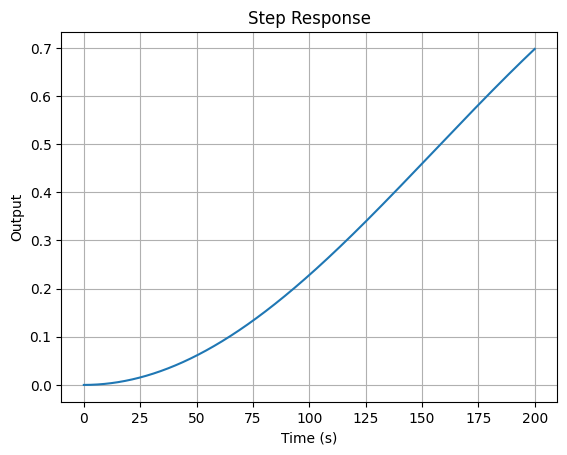

In [252]:
k = 0.01  # you can try different values

# Define transfer function: G(s)
num = [k, k * 1.001]
den = np.polymul([1, 1], [200, 0.05, 0.01])  # (s+1)(200s^2 + 0.05s + 0.01)
G = control.TransferFunction(num, den)

# Closed-loop transfer function T(s) = G / (1 + G)
T = control.feedback(G)

# Time vector for simulation
t = np.linspace(0, 200, 5000)  # you may adjust based on speed of response

# Step response
t, y = control.step_response(T, T=t)

# Compute performance metrics using step_info
info = control.step_info(T)

# Print results
print(f"Settling time (t_s)     = {info['SettlingTime']:.4f} s")
print(f"Peak time (t_p)         = {info['PeakTime']:.4f} s")
print(f"Overshoot (%)           = {info['Overshoot']:.2f} %")
print(f"Steady-state value      = {info['SteadyStateValue']:.4f}")

# Optional: Plot step response
plt.plot(t, y)
plt.title('Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.grid(True)
plt.show()